# SOSE SIC thickness timeseries/threshold

In [69]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1310, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.9/site

In [66]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.9ac9c51a52424201944eb382cc2070c9/status,


In [ ]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import json
import fsspec
import gcsfs
import xmitgcm

In [28]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [35]:
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))

/tmp/ipykernel_339/2800050246.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))


In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [5]:
coordsr = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
dsr.SIheff

<xarray.DataArray 'SIheff' (time: 438, YC: 320, XC: 2160)>
dask.array<open_dataset-a050d735e682b2f36299dae082225da8SIheff, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -25.04 -24.87 -24.71
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

In [70]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

coords = coordsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)
ds = dsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

sit = ds.SIheff

In [71]:
sit

<xarray.DataArray 'SIheff' (time: 438, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

In [72]:
mask = coords.hFacC[0]>0

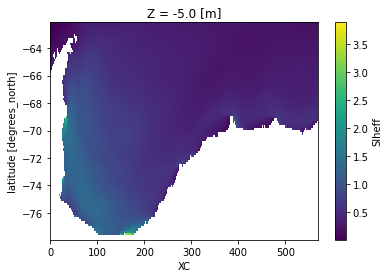

In [74]:
sit.where(mask).mean('time').drop('XC').plot();

In [75]:
sit_thresh = sit.where(sit <= 0.12).where(mask)
sit_thresh

<xarray.DataArray 'SIheff' (time: 438, YC: 95, XC: 570)>
dask.array<where, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Z        float32 -5.0
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

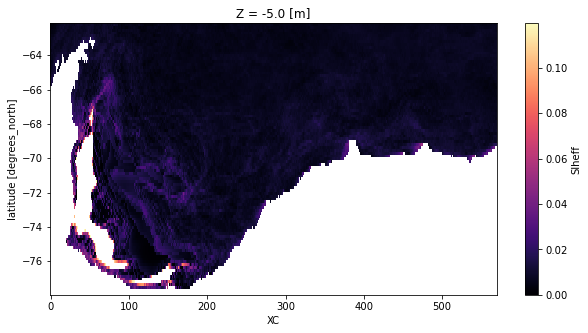

In [77]:
#look at same time as outcropping
sit_thresh.mean('time').drop('XC').plot(cmap='magma', figsize=(10,5));

## Check outcropping

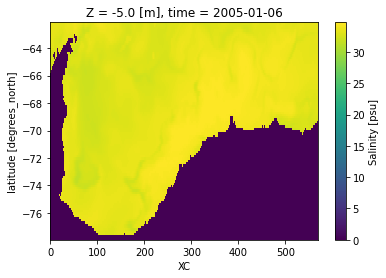

In [78]:
salt[0,0].drop('XC').plot()

In [ ]:
xr.testing.assert_equal(salt, ds_tns.SALT)

In [79]:
salt = ds.SALT
temp = ds.THETA

In [80]:
sigma2 = xr.apply_ufunc(jmd95numba.drhodt, salt, temp, 2000,
                            output_dtypes=[temp],
                            dask='parallelized').reset_coords(drop=True)

KeyboardInterrupt: 

In [16]:
sigma2

,Array,Chunk
Bytes,7.42 GiB,17.35 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,6572 Tasks,438 Chunks
Type,float64,numpy.ndarray


In [17]:
sigma2_m = sigma2.where(mask)

In [19]:
sigma2_m

,Array,Chunk
Bytes,7.42 GiB,17.35 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,7020 Tasks,438 Chunks
Type,float64,numpy.ndarray


2022-06-15 17:11:09,635 - distributed.protocol.pickle - INFO - Failed to serialize (subgraph_callable-df5acb2c-d913-42a0-8b7f-49a91a610a0b, array(nan), "('getitem-97754dd4ac9b17cdffd7551ae2f9d709', 0, 0)", 0, "('getitem-f9e88782576b9e13c6d36b05677208cb', 0, 0, 0, 0)", "('getitem-fb89236e07189d98dfdaeb1850040fec', 0, 0, 0, 0)", 2000). Exception: Can't pickle <ufunc 'rho'>: attribute lookup rho on __main__ failed
2022-06-15 17:11:09,638 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/protocol/core.py", line 110, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Pack

CancelledError: ('getitem-3c70e23272ed6e1e27d9ab947ad7eb76', 0, 0)

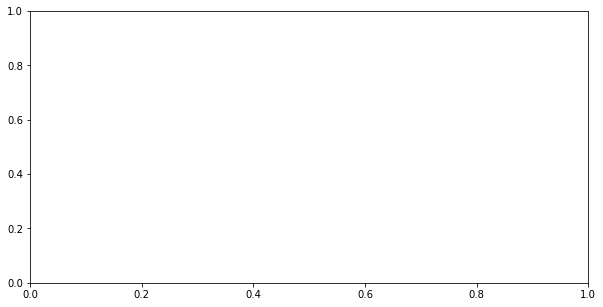

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
C = sigma2_m[0, 0].plot.contour(colors='yellow', levels=np.arange(1036.5, 1037.5, 0.025), ax=ax)
# makes first contour thicker and cyan, can do for contour line dividing bottom water (index 25 w current arange)
C.collections[0].set_color('cyan') 
C.collections[0].set_linewidth(3)
plt.clabel(C)
ds.TFLUX[0].where(mask).plot(cmap='seismic')

2022-06-15 15:13:58,176 - distributed.protocol.pickle - INFO - Failed to serialize (subgraph_callable-710d18ce-11b9-4e24-8939-9c33503cde02, array(nan), "('getitem-35639c1d02f38aedd3992861ee881305', 0, 0)", 0, "('getitem-f9e88782576b9e13c6d36b05677208cb', 0, 0, 0, 0)", "('getitem-fb89236e07189d98dfdaeb1850040fec', 0, 0, 0, 0)", 2000). Exception: Can't pickle <ufunc 'rho'>: attribute lookup rho on __main__ failed
2022-06-15 15:13:58,178 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/protocol/core.py", line 110, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Pack

CancelledError: ('getitem-5ce5bfb6423fb6fb90fad3a53582d686', 0, 0)

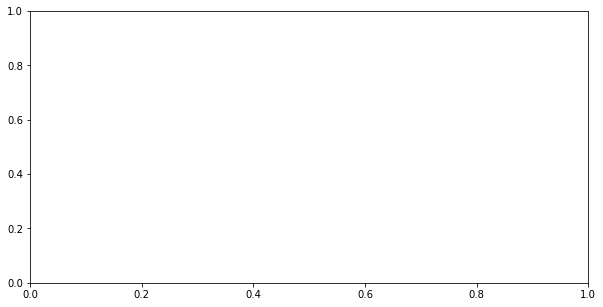

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
C = sigma2_m[0, 0].plot.contour(colors='yellow', levels=np.arange(1036.5, 1037.5, 0.025), ax=ax)
# makes first contour thicker and cyan, can do for contour line dividing bottom water (index 25 w current arange)
C.collections[0].set_linewidth(3)
plt.clabel(C)
sit_thresh[0].plot(cmap='magma')

2022-06-15 15:13:33,004 - distributed.protocol.pickle - INFO - Failed to serialize (<function getitem at 0x7f779d5535e0>, (subgraph_callable-af08a487-3c35-411f-8f32-57c976577387, array(nan), "('getitem-35639c1d02f38aedd3992861ee881305', 0, 0)", 0, "('getitem-f9e88782576b9e13c6d36b05677208cb', 50, 0, 0, 0)", "('getitem-fb89236e07189d98dfdaeb1850040fec', 50, 0, 0, 0)", 2000), (slice(None, None, None), 0, slice(None, None, None), slice(None, None, None))). Exception: Can't pickle <ufunc 'rho'>: attribute lookup rho on __main__ failed
2022-06-15 15:13:33,007 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/protocol/core.py", line 110, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/

CancelledError: ('getitem-33d68c7528d9a02694f503bf8bc141cb', 3, 0, 0)

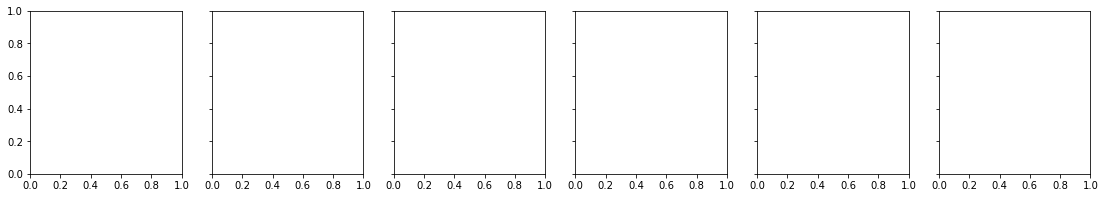

In [38]:
sigma2_m.sel(Z=0, time=['2005-06-14', '2005-07-15', '2005-08-15', '2005-09-15', '2005-10-14', '2005-11-14'],
                method='nearest').plot.contour(colors='cyan', levels=[1037.125], linewidth=8, label='', col='time')

sit_thresh.sel(time=['2005-06-14', '2005-07-15', '2005-08-15', '2005-09-15', '2005-10-14', '2005-11-14'],
                method='nearest').plot(cmap='magma', col='time');

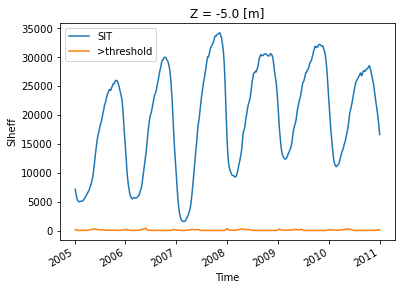

In [33]:
sit.where(mask).sum(['YC', 'XC']).plot(label='SIT')
sit_thresh.sum(['YC', 'XC']).plot(label='>threshold')
plt.legend();

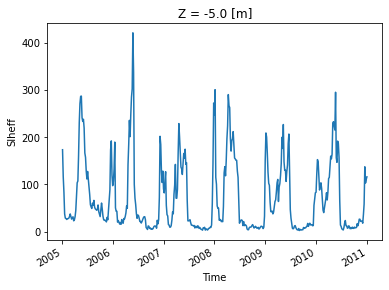

In [34]:
sit_thresh.sum(['YC', 'XC']).plot();

In [35]:
sit_thresh_anom = sit_thresh.groupby('time.month') - sit_thresh.groupby('time.month').mean()
sit_thresh_anom

<xarray.DataArray 'SIheff' (time: 438, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 51.75 51.92 52.08 52.25 ... 146.1 146.2 146.4 146.6
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Z        float32 -5.0
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

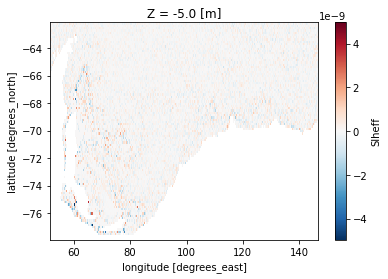

In [37]:
sit_thresh_anom.mean('time').plot();

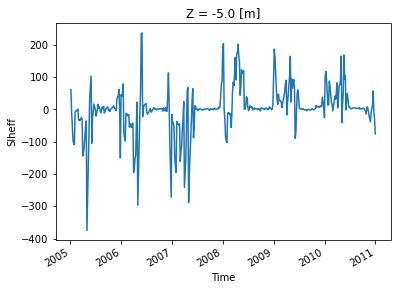

In [36]:
sit_thresh_anom.sum(['YC', 'XC']).plot();